# Distributed skeleton analysis with Dask

## Introduction to skeleton analysis

Lots of biological structures have a skeleton or network-like shape. We see these in all kinds of places, including:
* blood vessel branching
* the branching of airways
* neuron networks in the brain
* the root structure of plants
* the capillaries in leaves
* ... and many more

Analysing the structure of these skeletons can give us important information about the biology of that system.

### Create skeletons with scikit-image

The [scikit-image `skeletonize`](https://scikit-image.org/docs/dev/auto_examples/edges/plot_skeleton.html) function can be used to make image skeletons.

> Skeletonization reduces binary objects to 1 pixel wide representations. This can be useful for feature extraction, and/or representing an object’s topology.
>
> `skeletonize` works by making successive passes of the image. On each pass, border pixels are identified and removed on the condition that they do not break the connectivity of the corresponding object.


### Analyse skeletons with skan

[skan](https://jni.github.io/skan/) is a library for skeleton image analysis. Given a skeleton image, it can describe statistics of the branches. To make it fast, the library is accelerated with [numba](https://numba.pydata.org/) (if you're curious, you can hear more about that in [this talk](https://www.youtube.com/watch?v=0pUPNMglnaE) and its [related notebook](https://github.com/jni/skan-talk-scipy-2019)).

Here is a small, very simple skeleton image.

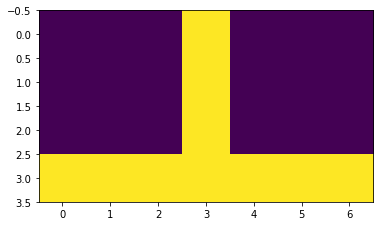

In [1]:
from skan._testdata import skeleton0 as skel
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(skel)

To calculate the skeleton graph from this, each non-zero pixel gets an integer id number

In [2]:
import numpy as np
import scipy.ndimage as ndi

ndim = skel.ndim

structure_kernel = np.zeros((3,) * ndim)
structure_kernel[(1,) * ndim] = 1  # add centre pixel
skelint, num_features = ndi.label(skel, structure=structure_kernel)

print(skelint)

[[ 0  0  0  1  0  0  0]
 [ 0  0  0  2  0  0  0]
 [ 0  0  0  3  0  0  0]
 [ 4  5  6  7  8  9 10]]


This happens inside the [`skeleton_to_csgraph`](https://jni.github.io/skan/api/skan.csr.html#skan.csr.skeleton_to_csgraph) function, which then goes on to calculate the skeleton graph.

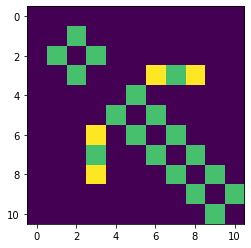

In [3]:
from skan import skeleton_to_csgraph

pixel_graph, coordinates, degrees = skeleton_to_csgraph(skel, unique_junctions=False)

plt.imshow(pixel_graph.todense())

Every two pixels that are connected in the original skeleton, become a point in the skeleton graph adjacency matrix (shown above). The location is determined by the integer id values of the pixels, and the value is determined by the distance between the pixel centers.

This article walks through the basics of how to create a skeleton graph adjacency matrix: https://people.revoledu.com/kardi/tutorial/GraphTheory/Adjacency-Matrix.html

In the skan documentation, it is described like this:

> The pixel graph is a SciPy [CSR matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html) in which entry *(i,j)* is 0 if pixels *i* and *j* are not connected, and otherwise is equal to the distance between pixels *i* and *j* in the skeleton

For more sophisticated analyses, the [`skan.Skeleton`](https://jni.github.io/skan/api/skan.csr.html#skan.csr.Skeleton)  class provides a way to keep all relevant information (the CSR matrix, the image, the node coordinates…) together.

In [4]:
from skan import Skeleton

skeleton_object = Skeleton(skel, unique_junctions=False)

A [`skan.Skeleton`](https://jni.github.io/skan/api/skan.csr.html#skan.csr.Skeleton) object contains the attributes:

* graph
* nbgraph
* coordinates
* paths
* n_paths
* distances
* _distances_initialized
* skeleton_image
* source_image
* degrees_image
* degrees
* spacing


We can see the skeleton graph belonging to it, just like before.

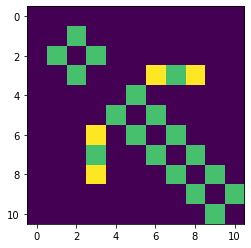

In [5]:
plt.imshow(skeleton_object.graph.todense())

### Skeleton branch statistics

Skeleton branch statistics can be calculated using the [skan `summarize`](https://jni.github.io/skan/api/skan.csr.html#skan.csr.summarize) function.

In [6]:
from skan import summarize

branch_data = summarize(skeleton_object)
branch_data

,skeleton-id,node-id-src,node-id-dst,branch-distance,branch-type,mean-pixel-value,stdev-pixel-value,image-coord-src-0,image-coord-src-1,image-coord-dst-0,image-coord-dst-1,coord-src-0,coord-src-1,coord-dst-0,coord-dst-1,euclidean-distance
0,1,1,3,2.000000,1,1.0,0.0,0.0,3.0,2.0,3.0,0.0,3.0,2.0,3.0,2.000000
1,1,3,6,1.414214,2,1.0,0.0,2.0,3.0,3.0,2.0,2.0,3.0,3.0,2.0,1.414214
2,1,3,7,1.000000,2,1.0,0.0,2.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,1.000000
3,1,3,8,1.414214,2,1.0,0.0,2.0,3.0,3.0,4.0,2.0,3.0,3.0,4.0,1.414214
4,1,4,6,2.000000,1,1.0,0.0,3.0,0.0,3.0,2.0,3.0,0.0,3.0,2.0,2.000000
5,1,8,10,2.000000,1,1.0,0.0,3.0,4.0,3.0,6.0,3.0,4.0,3.0,6.0,2.000000


## Distributed skeleton analysis with Dask

We want to do skeleton analysis on very large input images. We'll use Dask for this. First, we'll show the method for this using some test data. Then, we'll run distributed skeleton analysis on a real-world dataset.

We rely on one big assumption: once skeletonized the reduced non-zero pixel data will fit into memory. While this holds true for datasets of this size (the cropped rabbit lung datasets are roughly 1000 x 1000 x 1000 pixels), it may not hold true for much larger data.

### Start the Dask dashboard

In [7]:
from dask.distributed import Client

client = Client()
client

Client Scheduler: tcp://127.0.0.1:46543 Dashboard: http://127.0.0.1:39693/status,Cluster Workers: 4 Cores: 12 Memory: 16.54 GB


First we load the skeleton data into a Dask array.

In [8]:
import dask.array as da
from skan._testdata import skeleton0

skel = da.block([skeleton0, skeleton0])
print("chunks: ", skel.chunks)
skel

chunks:  ((4,), (7, 7))


dask.array<concatenate, shape=(4, 14), dtype=bool, chunksize=(4, 7), chunktype=numpy.ndarray>

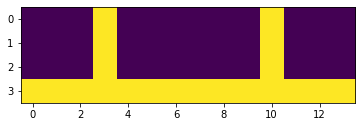

In [9]:
# This is what our very simple dask array looks like
plt.imshow(skel)

The [skan `skeleton_to_csgraph`](https://jni.github.io/skan/api/skan.csr.html#skan.csr.skeleton_to_csgraph) function is not currently compatible with Dask. (The latest skan version is currently 0.9.0). Because of this, we can't use this function directly, instread we need to calculate each piece for ourselves.

We label all the non-zero pixels with integer id numbers, using the `dask-image` library.

In [10]:
from dask_image.ndmeasure import label

ndim = skel.ndim
structure_kernel = np.zeros((3,) * ndim)
structure_kernel[(1,) * ndim] = 1  # add centre pixel
skelint, num_features = label(skel, structure=structure_kernel)

skelint.compute()  # show the result

array([[ 0,  0,  0,  1,  0,  0,  0,  0,  0,  0, 11,  0,  0,  0],
       [ 0,  0,  0,  2,  0,  0,  0,  0,  0,  0, 12,  0,  0,  0],
       [ 0,  0,  0,  3,  0,  0,  0,  0,  0,  0, 13,  0,  0,  0],
       [ 4,  5,  6,  7,  8,  9, 10, 14, 15, 16, 17, 18, 19, 20]],
      dtype=int32)

Next, we also label pixels based on how many neighbors they have in the skeleton. We can do this with the `convolve` function in `dask-image`.

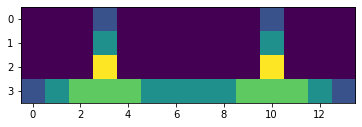

[[0 0 0 1 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 4 0 0 0 0 0 0 4 0 0 0]
 [1 2 3 3 3 2 2 2 2 3 3 3 2 1]]


In [11]:
from dask_image.ndfilters import convolve

degree_kernel = np.ones((3,) * ndim)
degree_kernel[(1,) * ndim] = 0  # remove centre pixel
degrees_image = convolve(skel.astype(int), degree_kernel,
                        mode='constant') * skel

# Show the results
plt.imshow(degrees_image)
plt.show()
print(degrees_image.compute())

To make the skeleton graph, it's a little more complicated. We'll have to use [Dask delayed](https://docs.dask.org/en/latest/delayed.html) on a function that will take in a chunk of the array and compute the values we need for the skeleton graph.

In [12]:
from dask.delayed import delayed
import pandas as pd
import numpy as np
import scipy

from skan.nputil import raveled_steps_to_neighbors
from skan.csr import _write_pixel_graph


@delayed
def skeleton_graph_func(skelint, spacing=1):
    ndim = skelint.ndim
    spacing = np.ones(ndim, dtype=float) * spacing
    num_edges = _num_edges(skelint.astype(bool))
    padded_skelint = np.pad(skelint, 1)  # pad image to prevent looparound errors
    steps, distances = raveled_steps_to_neighbors(padded_skelint.shape, ndim,
                                                  spacing=spacing)

    # from function skan.csr._pixel_graph
    row = np.empty(num_edges, dtype=int)
    col = np.empty(num_edges, dtype=int)
    data = np.empty(num_edges, dtype=float)
    k = _write_pixel_graph(padded_skelint, steps, distances, row, col, data)

    return pd.DataFrame({"row": row, "col": col, "data": data})

def _num_edges(skel):
    degree_kernel = np.ones((3,) * ndim)
    degree_kernel[(1,) * ndim] = 0  # remove centre pixel
    degree_image = scipy.ndimage.convolve(skel.astype(int),
                                          degree_kernel,
                                          mode='constant') * skel
    num_edges = np.sum(degree_image)
    return int(num_edges)

It's important to have a 1 pixel overlap between our array chunks, so that we can tell if a skeleton branch is ending or continuing on into the next chunk. For that, we'll need a way to grab the array chunk with a one pixel overlap. Ordinarily, we'd use `map_overlap` to handle that, but the ragged output shapes from the analysis function. Instead, here we'll write a function to slice an array chunk with some overlap.

In [13]:
# Mofified from slices_from_chunks from dask.array.core
from itertools import product
from dask.array.slicing import cached_cumsum


def slices_from_chunks_overlap(chunks, array_shape, depth=1):
    """Translate chunks tuple to a set of slices in product order

    Parameters
    ----------
    chunks : tuple
        The chunks of the corresponding dask array.
    array_shape : tuple
        Shape of the corresponding dask array.
    depth : int
        The number of pixels to overlap, providing we're not at the array edge.

    Example
    -------
    >>> slices_from_chunks_overlap(((4,), (7, 7)), (4, 14), depth=1)  # doctest: +NORMALIZE_WHITESPACE
     [(slice(0, 5, None), slice(0, 8, None)),
      (slice(0, 5, None), slice(6, 15, None))]
    """
    cumdims = [cached_cumsum(bds, initial_zero=True) for bds in chunks]

    slices = []
    for starts, shapes in zip(cumdims, chunks):
        inner_slices = []
        for s, dim, maxshape in zip(starts, shapes, array_shape):
            slice_start = s
            slice_stop = s + dim
            if slice_start > 0:
                slice_start -= depth
            if slice_stop >= maxshape:
                slice_stop += depth
            inner_slices.append(slice(slice_start, slice_stop))
        slices.append(inner_slices)
    
    return list(product(*slices))


With both of those things in place, we're ready to calculate the results.

In [14]:
import functools
import operator

import numpy as np
import dask.dataframe as dd


image = skelint

block_iter = zip(
    np.ndindex(*image.numblocks),
    map(functools.partial(operator.getitem, image),
        slices_from_chunks_overlap(image.chunks, image.shape, depth=1))
)

meta = dd.utils.make_meta([('row', np.int64), ('col', np.int64), ('data', np.float64)])  # it's very important to include meta
intermediate_results = [dd.from_delayed(skeleton_graph_func(block), meta=meta) for _, block in block_iter]
results = dd.concat(intermediate_results)

print(len(results))
results

48


,row,col,data
npartitions=2,,,
,int64,int64,float64
,...,...,...
,...,...,...


**Warning:** It's very important to pass in a `meta` keyword argument to the function `from_delayed`. Without it, things will be extremely inefficient!

If the `meta` keyword argument is not given, Dask will try and work out what it should be. Ordinarily that might be a good thing, but inside a list comprehension that means those tasks are computed slowly and sequentially before the main computation even begins, which is horribly inefficient. Since we know ahead of time what kinds of results we expect from our analysis function (we just don't know the length of each set of results), we can use the [`utils.make_meta`](https://docs.dask.org/en/latest/dataframe-api.html#dask.dataframe.utils.make_meta) function to help us here.

#### Dropping duplicates

It's necessary to drop any duplicates from these results. Any non-zero pixels in the overlapping region between chunks will have been accidentally counted twice.

In [15]:
# drop duplicates from the results
results = results.drop_duplicates()

In [16]:
# computes dask results, brings everything into memory before creating sparse graph
from scipy import sparse

k = len(results)
row = np.array(results['row'])
col = np.array(results['col'])
data = np.array(results['data'])

graph = sparse.coo_matrix((data[:k], (row[:k], col[:k]))).tocsr()
graph

<21x21 sparse matrix of type '<class 'numpy.float64'>'
	with 46 stored elements in Compressed Sparse Row format>

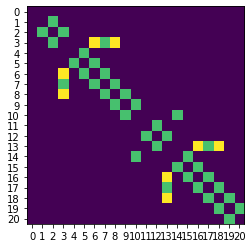

In [17]:
plt.xticks(ticks=np.arange(0, 21, 1))
plt.yticks(ticks=np.arange(0, 21, 1))
plt.imshow(graph.todense())

### Distributed analysis - skeleton branch statistics

Skeleton branch statistics can be calculate with the [skan `summarize`](https://jni.github.io/skan/api/skan.csr.html#skan.csr.summarize) function. The problem here is that the function expects a [`Skeleton`](https://jni.github.io/skan/api/skan.csr.html#skan.csr.Skeleton) object instance, but initializing a `Skeleton` object calls methods that are not compatible for distributed analysis.

We'll solve this problem by first initializing a [`Skeleton`](https://jni.github.io/skan/api/skan.csr.html#skan.csr.Skeleton) object instance with a tiny dummy dataset, then overwriting the attributes of the skeleton object with our real results. This is a hack, but it lets us achieve our goal: summary branch statistics for our large dataset.

First we make a Skeleton object instance with dummy data:


In [18]:
from skan import Skeleton

skel_obj = Skeleton(np.eye(5))  # initialize with dummy data

Now we overwrite the skeleton object attributes with the real data. We've already calculated some of these, and the others we'll calculate now.

Attributes belonging to the Skeleton class are:
* skeleton_image - the original boolean skeleton image
* source_image - you may have a raw image, before skeletonization
* spacing - the pixel spacing (default is 1)
* graph - the skeleton graph adjacency matrix
* nbgraph - a numba-compatible version of the skeleton graph
* n_paths - the number of paths through the skeleton
* paths - a list of each individual path through the skeleton
* degrees_image - image with each pixel labelled by the number of neighbors
* degrees - A 1D array of the non-zero pixel degree values, in order of the pixel id numbers
* distances - 


In [19]:
skel_obj.skeleton_image = skel
# skel_obj.source_image = raw_data  # if you have a raw data image
skel_obj.spacing = [1] * skel.ndim  # pixel/voxel size
skel_obj.graph = graph
skel_obj.degrees_image = degrees_image

In [20]:
# Calculate the degrees attribute
nonzero_degree_values = degrees_image[degrees_image > 0].compute()  # triggers Dask computation
degrees = np.concatenate((np.array([0]), nonzero_degree_values))

skel_obj.degrees = degrees

Skan also needs a numba-compatible version of the skeleton graph adjacency matrix. This is a little more complicated to create.

In [21]:
# node_prop for Skeleton class, so we can get the NBGraph (numba-ified graph)
nonzero_pixel_ids = skelint[skelint > 0]
sorted_indices = np.argsort(nonzero_pixel_ids)  # coerces to a numpy array, Dask doesn't implement argsort()

raw_data = da.random.random(skelint.shape)  # make some dummy data, since the test skeleton doesn't have a raw image
nonzero_pixel_intensity = raw_data[skelint > 0]
nonzero_pixel_intensity.compute_chunk_sizes()  # important, otherwise the indexing with sorted_indices thinks it's out of bounds
node_props = nonzero_pixel_intensity[sorted_indices].compute()  # trigger Dask computation
node_props = np.concatenate((np.array([0]), node_props))  # add a dummy index

from skan.csr import csr_to_nbgraph

nbgraph = csr_to_nbgraph(graph, node_props=None)  # node_props=None is the default
# nbgraph = csr_to_nbgraph(graph, node_props=node_props)  # node_props=None is the default

skel_obj.nbgraph = nbgraph

We also need to tell skan the non-zero pixel locations from our skeleton image.

In [22]:
pixel_indices = np.concatenate(([[0.] * ndim], np.transpose(np.nonzero(skel))), axis=0) # triggers Dask computation
skel_obj.coordinates = pixel_indices

And last we can use some of skan's methods and functions directly to calculate the skeleton paths and branch distances.

In [23]:
from skan.csr import _build_skeleton_path_graph

paths = _build_skeleton_path_graph(nbgraph, _buffer_size_offset=None)
skel_obj.paths = paths
skel_obj.n_paths = paths.shape[0]

In [24]:
# MUST reset both distances_intialized AND the empty numpy array to calculate the branch length
skel_obj._distances_initialized = False
skel_obj.distances = np.empty(skel_obj.n_paths, dtype=float)
skel_obj.path_lengths();

### Summary statistics from Dask array data

Now that we finally have all the Skeleton class attributes updated, we are ready to calculate branch statistics.

In [25]:
from skan import summarize

statistics = summarize(skel_obj)
statistics

,skeleton-id,node-id-src,node-id-dst,branch-distance,branch-type,mean-pixel-value,stdev-pixel-value,image-coord-src-0,image-coord-src-1,image-coord-dst-0,image-coord-dst-1,coord-src-0,coord-src-1,coord-dst-0,coord-dst-1,euclidean-distance
0,1,1,3,2.000000,1,1.0,0.0,0.0,3.0,1.0,3.0,0.0,3.0,1.0,3.0,1.000000
1,1,3,6,1.414214,2,1.0,0.0,1.0,3.0,2.0,10.0,1.0,3.0,2.0,10.0,7.071068
2,1,3,7,1.000000,1,1.0,0.0,1.0,3.0,3.0,0.0,1.0,3.0,3.0,0.0,3.605551
3,1,3,8,1.414214,2,1.0,0.0,1.0,3.0,3.0,1.0,1.0,3.0,3.0,1.0,2.828427
4,1,4,6,2.000000,2,1.0,0.0,1.0,10.0,2.0,10.0,1.0,10.0,2.0,10.0,1.000000
5,1,8,16,5.000000,2,1.0,0.0,3.0,1.0,3.0,9.0,3.0,1.0,3.0,9.0,8.000000
6,1,11,13,2.000000,2,1.0,0.0,3.0,4.0,3.0,6.0,3.0,4.0,3.0,6.0,2.000000
7,1,13,17,1.000000,2,1.0,0.0,3.0,6.0,3.0,10.0,3.0,6.0,3.0,10.0,4.000000
8,1,13,18,1.414214,2,1.0,0.0,3.0,6.0,3.0,11.0,3.0,6.0,3.0,11.0,5.000000
9,1,18,20,2.000000,1,1.0,0.0,3.0,11.0,3.0,13.0,3.0,11.0,3.0,13.0,2.000000


In [26]:
statistics.describe()

,skeleton-id,node-id-src,node-id-dst,branch-distance,branch-type,mean-pixel-value,stdev-pixel-value,image-coord-src-0,image-coord-src-1,image-coord-dst-0,image-coord-dst-1,coord-src-0,coord-src-1,coord-dst-0,coord-dst-1,euclidean-distance
count,10.0,10.000000,10.00000,10.000000,10.000000,10.0,10.0,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,1.0,7.700000,11.40000,1.924264,1.700000,1.0,0.0,1.900000,5.000000,2.600000,7.300000,1.900000,5.000000,2.600000,7.300000,3.650505
std,0.0,5.755191,6.07728,1.153356,0.483046,0.0,0.0,1.197219,3.265986,0.699206,4.522782,1.197219,3.265986,0.699206,4.522782,2.420701
min,1.0,1.000000,3.00000,1.000000,1.000000,1.0,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
25%,1.0,3.000000,6.25000,1.414214,1.250000,1.0,0.0,1.000000,3.000000,2.250000,3.750000,1.000000,3.000000,2.250000,3.750000,2.000000
50%,1.0,6.000000,10.50000,1.707107,2.000000,1.0,0.0,2.000000,3.500000,3.000000,9.500000,2.000000,3.500000,3.000000,9.500000,3.216989
75%,1.0,12.500000,16.75000,2.000000,2.000000,1.0,0.0,3.000000,6.000000,3.000000,10.000000,3.000000,6.000000,3.000000,10.000000,4.750000
max,1.0,18.000000,20.00000,5.000000,2.000000,1.0,0.0,3.000000,11.000000,3.000000,13.000000,3.000000,11.000000,3.000000,13.000000,8.000000


### Visualization

In [27]:
import seaborn as sns

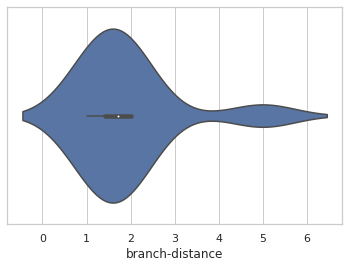

In [28]:
sns.set_theme(style="whitegrid")
ax = sns.violinplot(x=statistics["branch-distance"])

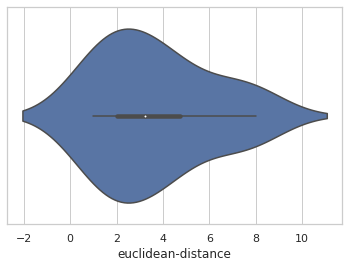

In [29]:
sns.set_theme(style="whitegrid")
ax = sns.violinplot(x=statistics["euclidean-distance"])

## Distributed skeleton analysis of the blood vessels within a lung

For this example, we will look at the blood vessels inside of a lung. This data was shared with us by [Marcus Kitchen](https://research.monash.edu/en/persons/marcus-kitchen), [Andrew Stainsby](https://hudson.org.au/researcher-profile/andrew-stainsby/), and their team of collaborators. This research group focusses on lung development.

### Read in the data

In [30]:
filename = "data/1740_p4_left.tif"  # CT scan of a healthy lung

In [31]:
import dask.array as da
from dask_image.imread import imread

original_image = imread(filename)
original_image

dask.array<_map_read_frame, shape=(1224, 890, 702), dtype=float32, chunksize=(1, 890, 702), chunktype=numpy.ndarray>

In [32]:
print(original_image.shape)

(1224, 890, 702)


### Smooth images

There is some shot noise in the pixels of the raw data. We can blur the images very slightly to improve the quality of the segmentation of the blood vessels.

In [33]:
from dask_image.ndfilters import gaussian_filter

sigma_value = 2.0
smoothed = gaussian_filter(original_image, sigma=sigma_value)

### Segment the blood vessels



In [34]:
threshold_value = 0.45
binary_image = smoothed > threshold_value

Here's a screenshot of the segmented blood vessels, before thinning the skeleton.

![Skeleton network of blood vessels within a healthy lung](skeleton-screenshot-crop.jpg)

### Rechunk to a more sensible shape

Now we need to [rechunk](https://docs.dask.org/en/latest/array-chunks.html?highlight=rechunk#rechunking) the Dask array. We change the chunk shapes from 2D slices to small cuboid volumes, so the skeletonization step is efficient. We can choose the overall size of the chunks so that we can stay under the memory threshold needed for skeletonize.

In [35]:
factor = np.array([4,4,4])  # even numbers
desired_chunksize = np.array(binary_image.shape)//factor

print(desired_chunksize)

[306 222 175]


In [36]:
rechunked_binary_image = binary_image.rechunk(desired_chunksize)

In [37]:
rechunked_binary_image

dask.array<rechunk-merge, shape=(1224, 890, 702), dtype=bool, chunksize=(306, 222, 175), chunktype=numpy.ndarray>

### Skeletonize

If we use the [`skeletonize` function](https://scikit-image.org/docs/dev/auto_examples/edges/plot_skeleton.html) without Dask, we get crashes due to out-of-memory errors (running on a laptop limited to 16GB RAM, for a dataset of this size). Using Dask, we can run `skeletonize` on the array chunks using [`map_overlap`](https://docs.dask.org/en/latest/array-overlap.html). By limiting the size of the array chunks, we stay under our memory threshold!


In [38]:
from skimage.morphology import skeletonize

skeleton = da.map_overlap(skeletonize, rechunked_binary_image)

### Skeleton analysis

Now we can use the distributed skeleton analysis method we developed earlier, on this dataset.

In [39]:
skel = skeleton
ndim = skel.ndim

In [40]:
# Label each non-zero pixel with a unique integer id
structure_kernel = np.zeros((3,) * ndim)
structure_kernel[(1,) * ndim] = 1  # add centre pixel
skelint, num_features = label(skel, structure=structure_kernel)

In [41]:
# Label each non-zero pixel with the number of neighbors it has
degree_kernel = np.ones((3,) * ndim)
degree_kernel[(1,) * ndim] = 0  # remove centre pixel
degrees_image = convolve(skel.astype(int), degree_kernel, mode='constant') * skel

In [42]:
# Calculate the results we need to make the skeleton graph
image = skelint
block_iter = zip(
    np.ndindex(*image.numblocks),
    map(functools.partial(operator.getitem, image),
        slices_from_chunks_overlap(image.chunks, image.shape, depth=1))
)

meta = dd.utils.make_meta([('row', np.int64), ('col', np.int64), ('data', np.float64)])  # it's very important to include meta
intermediate_results = [dd.from_delayed(skeleton_graph_func(block), meta=meta) for _, block in block_iter]  # this appears to be triggering a lot of computation
results = dd.concat(intermediate_results)
results = results.drop_duplicates()

In [43]:
# Create the skeleton graph adjacency matrix
k = len(results)
row = np.array(results['row'])
col = np.array(results['col'])
data = np.array(results['data'])

graph = sparse.coo_matrix((data[:k], (row[:k], col[:k]))).tocsr()
graph

<26823x26823 sparse matrix of type '<class 'numpy.float64'>'
	with 37836 stored elements in Compressed Sparse Row format>

### Skeleton branch statistics

In [44]:
skel_obj = Skeleton(np.eye(5))  # initialize with dummy data

In [45]:
skel_obj.skeleton_image = skel
skel_obj.source_image = original_image  # if you have a raw data image
skel_obj.spacing = [1] * skel.ndim  # pixel/voxel size
skel_obj.graph = graph
skel_obj.degrees_image = degrees_image

In [46]:
# Calculate the degrees attribute
nonzero_degree_values = degrees_image[degrees_image > 0].compute()  # triggers Dask computation
degrees = np.concatenate((np.array([0]), nonzero_degree_values))
skel_obj.degrees = degrees

In [47]:
# Create a numba-compatible version of the skeleton graph adjacency matrix
# node_prop for Skeleton class, so we can get the NBGraph (numba-ified graph)
nonzero_pixel_ids = skelint[skelint > 0]
sorted_indices = np.argsort(nonzero_pixel_ids)  # coerces to a numpy array, Dask doesn't implement argsort()

raw_data = original_image
nonzero_pixel_intensity = raw_data[skelint > 0]
nonzero_pixel_intensity.compute_chunk_sizes()  # important, otherwise the indexing with sorted_indices thinks it's out of bounds
node_props = nonzero_pixel_intensity[sorted_indices].compute()  # trigger Dask computation
node_props = np.concatenate((np.array([0]), node_props))  # add a dummy index

from skan.csr import csr_to_nbgraph

nbgraph = csr_to_nbgraph(graph, node_props=node_props)  # node_props=None is the default
# nbgraph = csr_to_nbgraph(graph, node_props=node_props)  # node_props=None is the default

skel_obj.nbgraph = nbgraph

We also need to tell skan the non-zero pixel locations from our skeleton image.

In [48]:
# We also need to tell skan the non-zero pixel locations from our skeleton image.
pixel_indices = np.concatenate(([[0.] * ndim], np.transpose(np.nonzero(skel))), axis=0) # triggers Dask computation
skel_obj.coordinates = pixel_indices

And last we can use some of skan's methods and functions directly to calculate the skeleton paths and branch distances.

In [49]:
from skan.csr import _build_skeleton_path_graph

paths = _build_skeleton_path_graph(nbgraph, _buffer_size_offset=None)
skel_obj.paths = paths
skel_obj.n_paths = paths.shape[0]

In [50]:
# MUST reset both distances_intialized AND the empty numpy array to calculate the branch length
skel_obj._distances_initialized = False
skel_obj.distances = np.empty(skel_obj.n_paths, dtype=float)
skel_obj.path_lengths();

### Summary statistics from Dask blood vessel data

Now that we finally have all the Skeleton class attributes updated, we are ready to calculate branch statistics.

In [51]:
from skan import summarize

statistics = summarize(skel_obj)
statistics

,skeleton-id,node-id-src,node-id-dst,branch-distance,branch-type,mean-pixel-value,stdev-pixel-value,image-coord-src-0,image-coord-src-1,image-coord-src-2,image-coord-dst-0,image-coord-dst-1,image-coord-dst-2,coord-src-0,coord-src-1,coord-src-2,coord-dst-0,coord-dst-1,coord-dst-2,euclidean-distance
0,1,1,2,1.000000,2,1.0,0.0,22.0,400.0,595.0,22.0,400.0,596.0,22.0,400.0,595.0,22.0,400.0,596.0,1.000000
1,2,3,9,8.196152,2,1.0,0.0,37.0,400.0,622.0,43.0,392.0,590.0,37.0,400.0,622.0,43.0,392.0,590.0,33.526109
2,3,10,11,1.000000,2,1.0,0.0,49.0,391.0,589.0,50.0,391.0,589.0,49.0,391.0,589.0,50.0,391.0,589.0,1.000000
3,5,13,19,6.828427,2,1.0,0.0,52.0,389.0,588.0,55.0,385.0,588.0,52.0,389.0,588.0,55.0,385.0,588.0,5.000000
4,7,21,23,2.000000,2,1.0,0.0,57.0,382.0,587.0,58.0,380.0,586.0,57.0,382.0,587.0,58.0,380.0,586.0,2.449490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,2617,21386,21388,1.414214,2,1.0,0.0,828.0,341.0,289.0,828.0,365.0,130.0,828.0,341.0,289.0,828.0,365.0,130.0,160.801119
1091,2617,21388,21395,9.071068,2,1.0,0.0,828.0,365.0,130.0,828.0,559.0,272.0,828.0,365.0,130.0,828.0,559.0,272.0,240.416306
1092,6938,25715,25719,11.071068,2,1.0,0.0,935.0,802.0,354.0,936.0,454.0,251.0,935.0,802.0,354.0,936.0,454.0,251.0,362.924235
1093,8034,26820,26822,2.000000,2,1.0,0.0,976.0,214.0,176.0,976.0,264.0,256.0,976.0,214.0,176.0,976.0,264.0,256.0,94.339811


In [52]:
statistics.describe()

,skeleton-id,node-id-src,node-id-dst,branch-distance,branch-type,mean-pixel-value,stdev-pixel-value,image-coord-src-0,image-coord-src-1,image-coord-src-2,image-coord-dst-0,image-coord-dst-1,image-coord-dst-2,coord-src-0,coord-src-1,coord-src-2,coord-dst-0,coord-dst-1,coord-dst-2,euclidean-distance
count,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.0,1095.0,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000
mean,2089.382648,11520.147945,11608.591781,22.907940,2.000913,1.0,0.0,591.938813,430.303196,377.409132,594.325114,436.596347,373.419178,591.938813,430.303196,377.409132,594.325114,436.596347,373.419178,190.129504
std,636.376786,6057.613236,6061.182631,24.264591,0.030220,0.0,0.0,174.039923,194.499360,97.021882,173.352860,188.707738,96.827617,174.039923,194.499360,97.021882,173.352860,188.707738,96.827617,151.170588
min,1.000000,1.000000,2.000000,1.000000,2.000000,1.0,0.0,22.000000,39.000000,116.000000,22.000000,39.000000,114.000000,22.000000,39.000000,116.000000,22.000000,39.000000,114.000000,0.000000
25%,1586.000000,6215.500000,6429.500000,1.732051,2.000000,1.0,0.0,468.500000,278.500000,313.000000,475.000000,299.500000,307.000000,468.500000,278.500000,313.000000,475.000000,299.500000,307.000000,72.694566
50%,2431.000000,11977.000000,12010.000000,16.681434,2.000000,1.0,0.0,626.000000,405.000000,388.000000,627.000000,410.000000,381.000000,626.000000,405.000000,388.000000,627.000000,410.000000,381.000000,161.058995
75%,2542.500000,16526.500000,16583.000000,35.043330,2.000000,1.0,0.0,732.000000,579.000000,434.000000,734.000000,590.000000,432.000000,732.000000,579.000000,434.000000,734.000000,590.000000,432.000000,265.948297
max,8034.000000,26820.000000,26822.000000,197.146555,3.000000,1.0,0.0,976.000000,833.000000,622.000000,976.000000,841.000000,606.000000,976.000000,833.000000,622.000000,976.000000,841.000000,606.000000,737.835347


### Visualization

In [53]:
import seaborn as sns

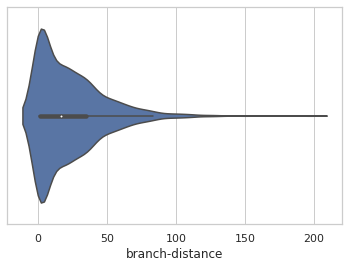

In [54]:
sns.set_theme(style="whitegrid")
ax = sns.violinplot(x=statistics["branch-distance"])

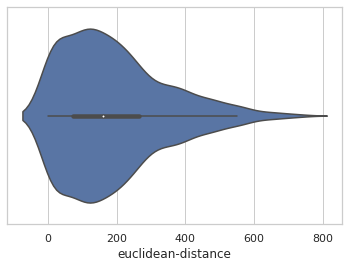

In [55]:
sns.set_theme(style="whitegrid")
ax = sns.violinplot(x=statistics["euclidean-distance"])